# Deep learning A-Z : Building a SOM

<p align="justify">
This notebook is my response to the fourth homework of the course called *Deep Learning A-Z™: Hands-On Artificial Neural Networks* accessible here : https://www.udemy.com/deeplearning/
</p>
<p align="justify">
In this notebook, we are going to build a Self Organizing Map (SOM) using minisom by following instructions given on the course. This will allow us to detect potential credit card fraud among customers who bought a credit card. We will use unsupervised learning to detect patterns (segments of customers) in data and one of those parttern will be the potential fraud.
</p>

### Imports

In [12]:
import os
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from minisom import MiniSom
from pylab import bone, pcolor, colorbar, plot, show

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

### 1. Data preprocessing

The fraud detection will consist of identifiying outliers with a SOM. We will compute the mean of eclidian distance betweet a point and its neighborhood on the SOM. The points which will have the biggest MED will be the outliers (the potential fraudsters).

In [4]:
path_train = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath('__file__')))), 'ressources/Self_Organizing_Maps/Credit_Card_Applications.csv')
dataset = pd.read_csv(path_train)
dataset.head()

,CustomerID,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,Class
0,15776156,1,22.08,11.46,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,15739548,0,22.67,7.00,2,8,4,0.165,0,0,0,0,2,160,1,0
2,15662854,0,29.58,1.75,1,4,4,1.250,0,0,0,1,2,280,1,0
3,15687688,0,21.67,11.50,1,5,3,0.000,1,1,11,1,2,0,1,1
4,15715750,1,20.17,8.17,2,6,4,1.960,1,1,14,0,2,60,159,1


In [5]:
dataset.shape

(690, 16)

Last column contain informaton about if clients application was approuved of not. In this way, we will be able to compare, on the SOM, the customers who have approuval and those who do not have it (so we will be able to identify the customers who are fraudulent and who got their application approved).

In [6]:
# Attributes
X = dataset.iloc[:, :-1].values
# Class (approved of not)
y = dataset.iloc[:, -1].values

In [7]:
# Features scaling (normalization)
sc = MinMaxScaler(feature_range=(0,1))
X = sc.fit_transform(X)
X

array([[8.42681467e-01, 1.00000000e+00, 1.25263158e-01, ...,
        5.00000000e-01, 5.00000000e-02, 1.21200000e-02],
       [6.96090562e-01, 0.00000000e+00, 1.34135338e-01, ...,
        5.00000000e-01, 8.00000000e-02, 0.00000000e+00],
       [3.88981656e-01, 0.00000000e+00, 2.38045113e-01, ...,
        5.00000000e-01, 1.40000000e-01, 0.00000000e+00],
       ...,
       [4.39420332e-01, 0.00000000e+00, 7.63909774e-02, ...,
        5.00000000e-01, 5.00000000e-02, 0.00000000e+00],
       [8.44034934e-01, 0.00000000e+00, 2.05563910e-01, ...,
        5.00000000e-01, 6.00000000e-02, 1.10000000e-04],
       [1.06907888e-01, 1.00000000e+00, 4.09774436e-01, ...,
        0.00000000e+00, 2.80000000e-01, 0.00000000e+00]])

### 2. Building the SOM

In [27]:
# initializing som
som = MiniSom(x=10, y=10, input_len=15)

- *x, y* is the size of the grid for the SOM
- *input_len* is the number of features in our dataset
- *learning rate* higher lr means quicker convergence

In [28]:
som.random_weights_init(X) # initializing weights randomly close to 0
som.train_random(data=X, num_iteration=100) # We don't train on X and y, just on X because it's unsueprvised learning

### 3. Plot the SOM

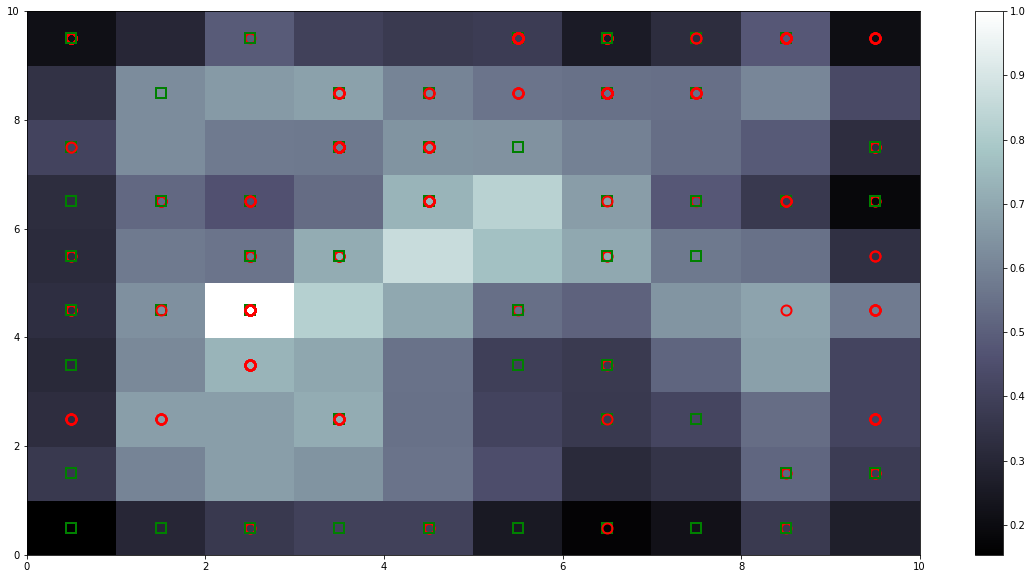

In [29]:
plt.figure(figsize=(20,10))
pcolor(som.distance_map().T) # distance_map method will return all the mean distances for winning nodes in one matrix
colorbar()

# add red circles and green squares for customer who did not get approval and customer who got approval respectively
markers = ['o', 's']
colors = ['r', 'g']

for i, x in enumerate(X):
    w = som.winner(x) # get coordinate of winning node for observation x
    plot(w[0] + 0.5, 
         w[1] + 0.5, # plot marker AT THE MIDDLE of the square representing the winning node
         markers[y[i]],
         markeredgecolor=colors[y[i]],
         markerfacecolor='None',
         markersize=10, # graphical settings
         markeredgewidth=2) 

show()

We can clearly see that, on the white squared representing the outliers (so the potential frauds), there are customers which received an approval and customers which did not received the approval. Now, we have to catch the cheaters, in priority the ones who get approvals.

### 4. Finding the frauds

In [41]:
mapping = som.win_map(X) # dict containing the observations pet node of the SOM
frauds = mapping[2, 4] # get customers in white winning node of SOM above
# frauds = np.concatenate((mapping[2, 4], mapping[, ]), axis=0) # to concatenate 2 nodes

In [42]:
frauds = sc.inverse_transform(frauds)
frauds = pd.DataFrame(frauds, columns=dataset.columns.tolist()[:-1])
frauds.head()

,CustomerID,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14
0,15662854.0,0.0,29.58,1.750,1.0,4.0,4.0,1.25,0.0,0.0,0.0,1.0,2.0,280.0,1.0
1,15610042.0,0.0,20.42,10.500,1.0,14.0,8.0,0.00,0.0,0.0,0.0,1.0,2.0,154.0,33.0
2,15568162.0,0.0,19.50,0.165,2.0,11.0,4.0,0.04,0.0,0.0,0.0,1.0,2.0,380.0,1.0
3,15590434.0,0.0,25.00,0.875,2.0,14.0,8.0,1.04,1.0,0.0,0.0,1.0,2.0,160.0,5861.0
4,15745375.0,0.0,33.08,1.625,2.0,2.0,4.0,0.54,0.0,0.0,0.0,1.0,2.0,0.0,1.0


Finally, we have the list of potential frauds !